In [43]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [44]:
state = 'MP'

In [45]:
c_dataset = pd.read_csv("Confirmed - copy.csv")
c_dataset['Date'] = pd.to_datetime(c_dataset['Date'], infer_datetime_format=True)
c_data = c_dataset.set_index(['Date'])
c_data = c_data[[state]]
c_data[state] = c_data[state].fillna(0)

In [46]:
cases = c_data[state].resample('D').mean()#D,W,MS

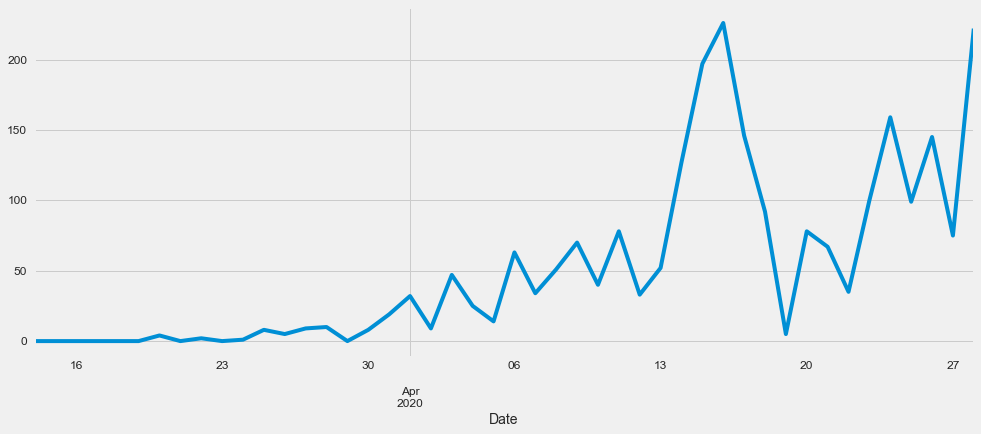

In [47]:
cases.plot(figsize=(15, 6))
plt.show()

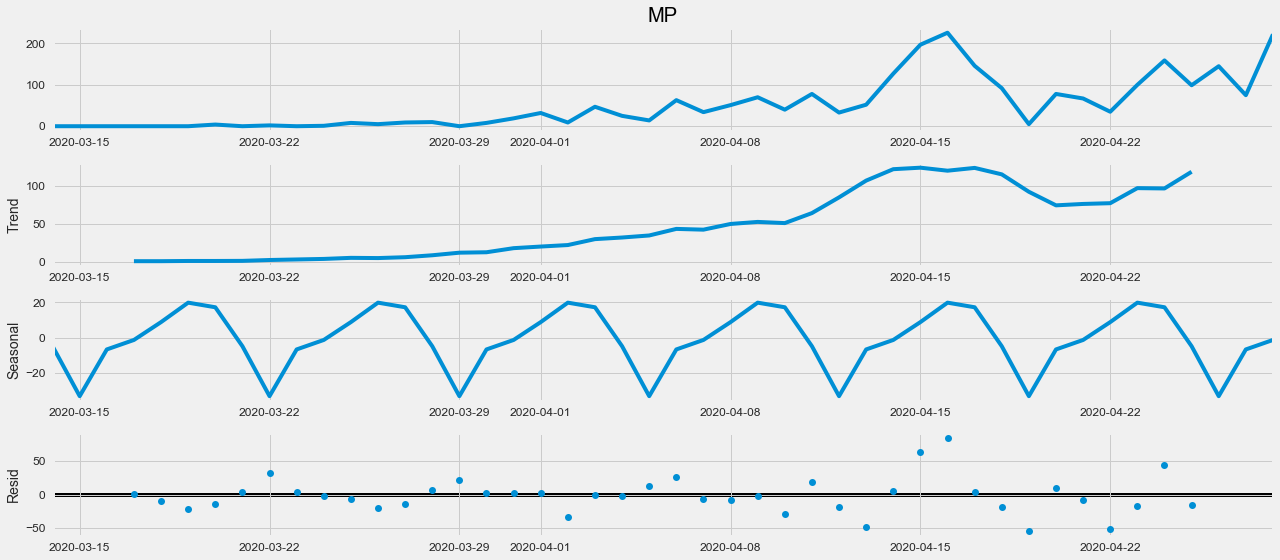

In [48]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
c_decomposition = sm.tsa.seasonal_decompose(cases, model='additive')
c_fig = c_decomposition.plot()
plt.show()

In [49]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [50]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            cases_mod = sm.tsa.statespace.SARIMAX(cases,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            cases_results = cases_mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, cases_results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:525.5604414909772
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1472.5197505633016
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:373.8138548882078
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:248.88512286763014
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:386.0173082648855
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1380.3955375017276
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:259.65096314463835
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:247.5853201277593
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:492.4268578718081
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:352.31198369841434
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:231.4961169921707
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:374.33693097847447
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2926.1797107560114
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:252.4465394378169
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:233.49606336394586
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:460.5121758763064
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1548.9454813677835
ARIMA(0, 1, 0)x

In [51]:
c_mod = sm.tsa.statespace.SARIMAX(cases,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
cases_results = c_mod.fit()
print(cases_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4485      0.211      2.123      0.034       0.034       0.863
ma.L1         -1.0000      0.537     -1.863      0.063      -2.052       0.052
ma.S.L12      -0.6441      0.480     -1.341      0.180      -1.585       0.297
sigma2      2989.8689      0.000   1.67e+07      0.000    2989.869    2989.869


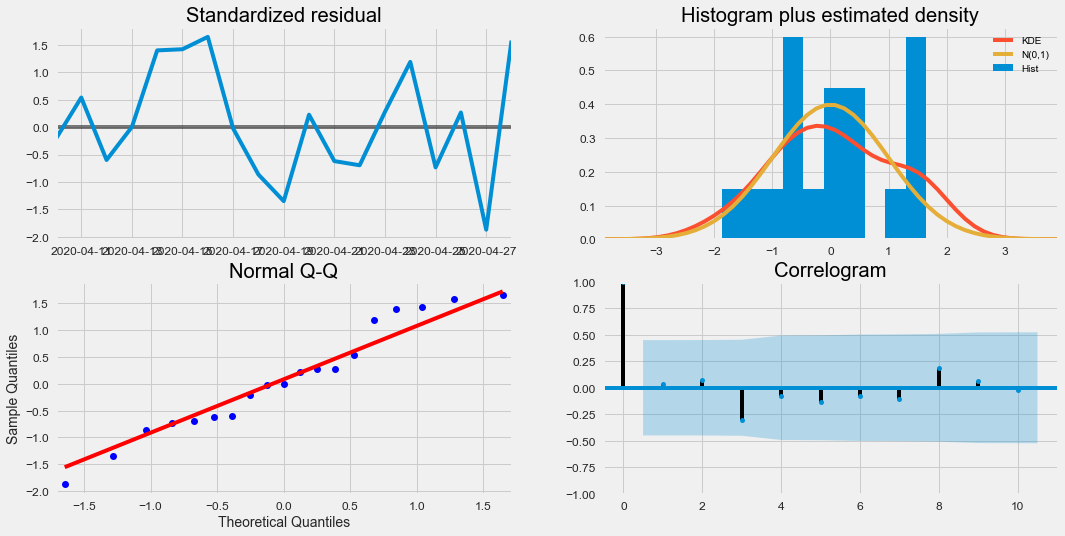

In [52]:
cases_results.plot_diagnostics(figsize=(16, 8))
plt.show()

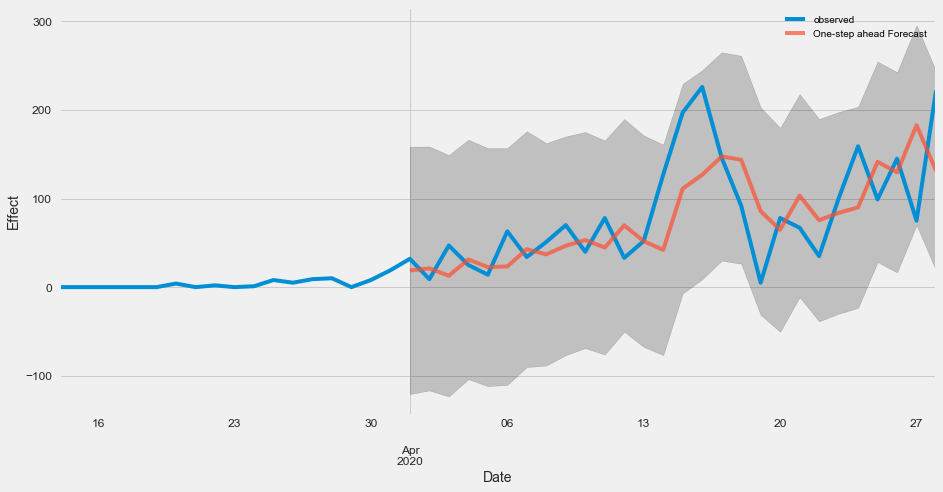

In [53]:
cases_pred = cases_results.get_prediction(start=pd.to_datetime('2020-04-01'), dynamic=False)
cases_pred_ci = cases_pred.conf_int()
cases_ax = cases['2020':].plot(label='observed')
cases_pred.predicted_mean.plot(ax=cases_ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
cases_ax.fill_between(cases_pred_ci.index,
                cases_pred_ci.iloc[:, 0],
                cases_pred_ci.iloc[:, 1], color='k', alpha=.2)
cases_ax.set_xlabel('Date')
cases_ax.set_ylabel('Effect')
plt.legend()
plt.show()

In [54]:
cases_forecasted = cases_pred.predicted_mean
cases_truth = cases['2020-04-01':]
cases_mse = ((cases_forecasted - cases_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(cases_mse, 2)))

The Mean Squared Error of our forecasts is 2509.72


In [55]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(cases_mse), 2)))

The Root Mean Squared Error of our forecasts is 50.1


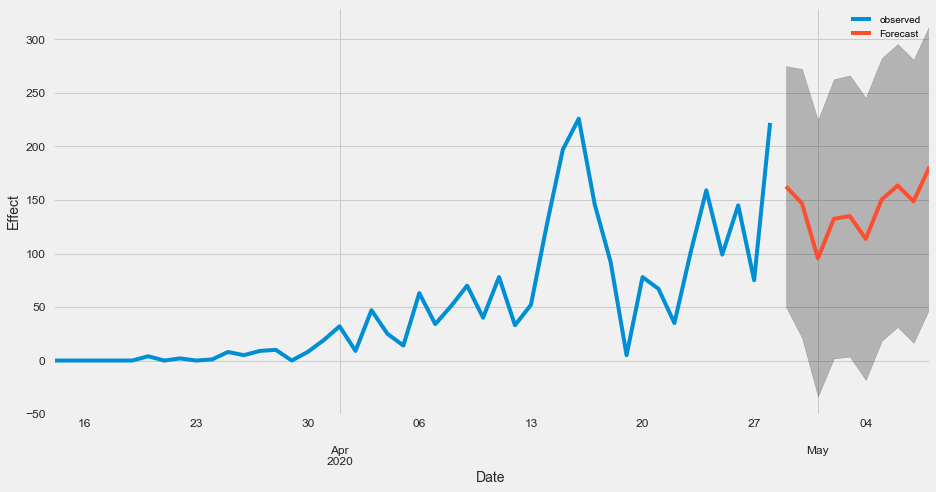

In [56]:
cases_pred_uc = cases_results.get_forecast(steps=10)
cases_pred_ci = cases_pred_uc.conf_int()
cases_ax = cases.plot(label='observed', figsize=(14, 7))
cases_pred_uc.predicted_mean.plot(ax=cases_ax, label='Forecast')
cases_ax.fill_between(cases_pred_ci.index,
                cases_pred_ci.iloc[:, 0],
                cases_pred_ci.iloc[:, 1], color='k', alpha=.25)
cases_ax.set_xlabel('Date')
cases_ax.set_ylabel('Effect')
plt.legend()
plt.show()

In [57]:
r_dataset = pd.read_csv("Recovered.csv")
r_dataset['Date'] = pd.to_datetime(r_dataset['Date'], infer_datetime_format=True)
r_data = r_dataset.set_index(['Date'])
r_data = r_data[[state]]
r_data[state] = r_data[state].fillna(0)

In [58]:
total_data = pd.DataFrame()
total_data['Cases'] = c_data[state]
total_data['Recovered'] = r_data[state]

In [59]:
total_data.tail()

,Cases,Recovered
Date,,
2020-04-24,159.0,7
2020-04-25,99.0,71
2020-04-26,145.0,21
2020-04-27,75.0,55
2020-04-28,222.0,16


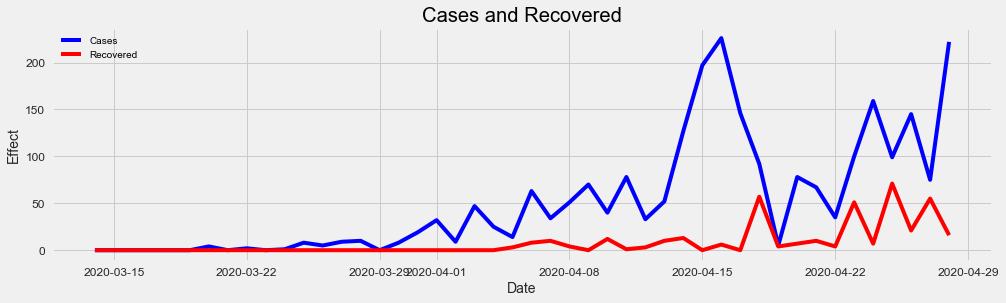

In [60]:
plt.figure(figsize=(15, 4))
plt.plot(total_data.index, total_data['Cases'], 'b-', label = 'Cases')
plt.plot(total_data.index, total_data['Recovered'], 'r-', label = 'Recovered')
plt.xlabel('Date'); plt.ylabel('Effect'); plt.title('Cases and Recovered')
plt.legend()
plt.show()

In [61]:
recovered = total_data['Recovered'].resample('D').mean()

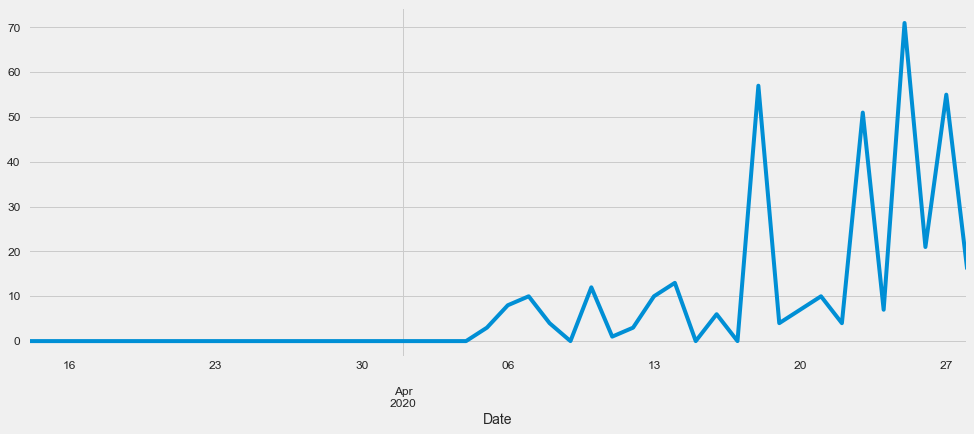

In [62]:
recovered.plot(figsize=(15, 6))
plt.show()

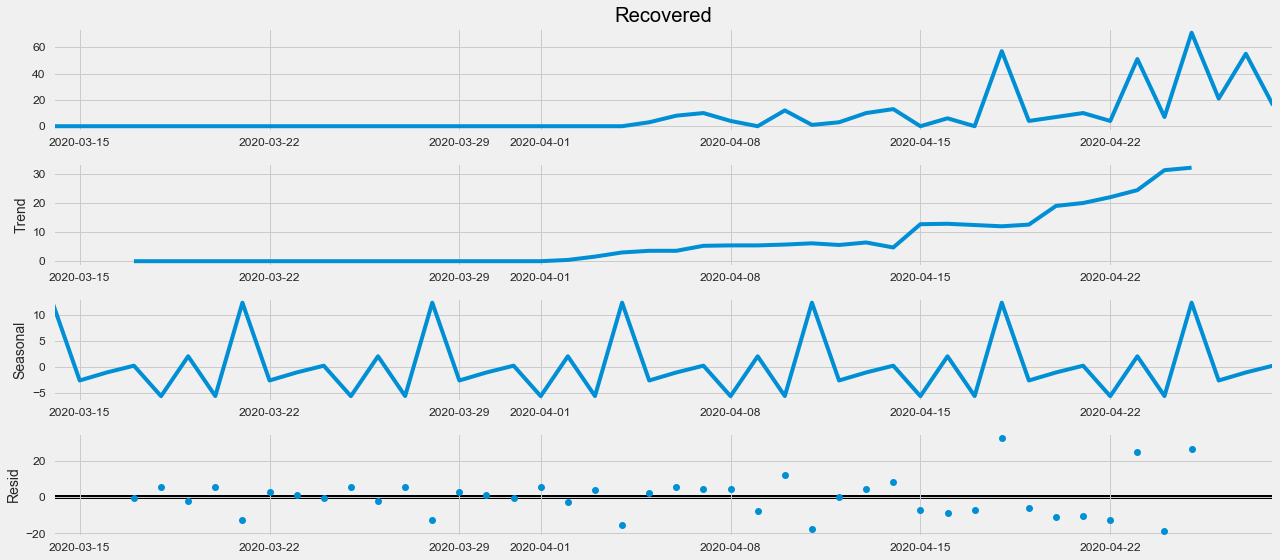

In [63]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
recovered_decomposition = sm.tsa.seasonal_decompose(recovered, model='additive')
fig = recovered_decomposition.plot()
plt.show()

In [64]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            recovered_mod = sm.tsa.statespace.SARIMAX(recovered,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            recovered_results = recovered_mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, recovered_results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:392.56530804521924
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1033.6801925228312
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:292.0757896724922
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:196.59935413335495
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:296.70319604728985
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:952.3111114728694
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:202.8254791053741
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:196.63123112846338
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:384.42171342874906
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:944.6162519410611
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:286.1127440191107
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:190.38548887434564
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:294.270097665088
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:922.7783945370194
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:201.6553771306424
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:187.3265777992237
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:396.5273675186502
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1097.5050108504204
ARI

In [65]:
#ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:199.83565329572556
recovered_mod = sm.tsa.statespace.SARIMAX(recovered,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
recovered_results = recovered_mod.fit()
print(recovered_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7743      0.175     -4.421      0.000      -1.118      -0.431
ma.L1         -0.4625      0.229     -2.019      0.044      -0.912      -0.013
ma.S.L12       0.4308      1.211      0.356      0.722      -1.943       2.804
sigma2       295.6160    142.106      2.080      0.038      17.093     574.139


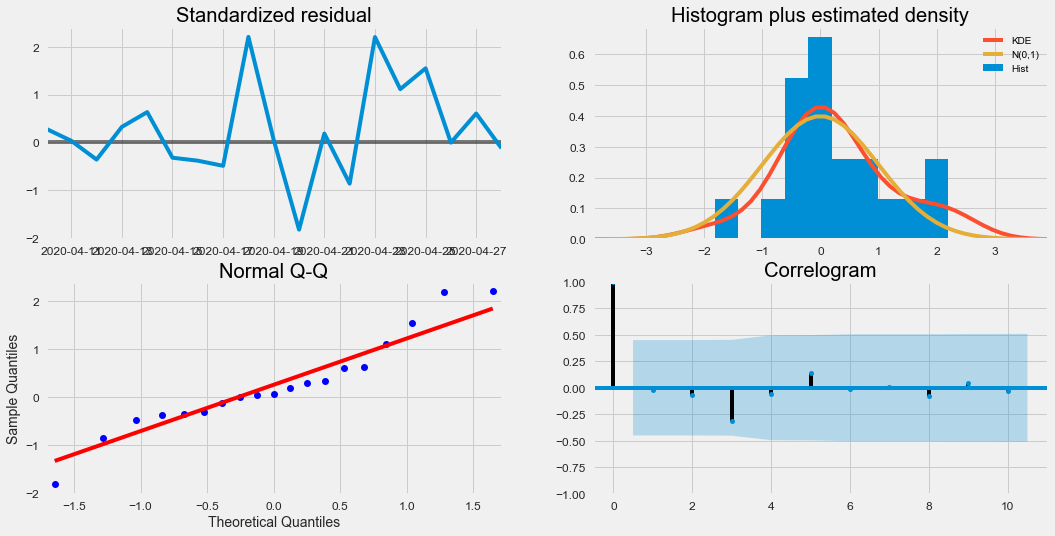

In [66]:
recovered_results.plot_diagnostics(figsize=(16, 8))
plt.show()

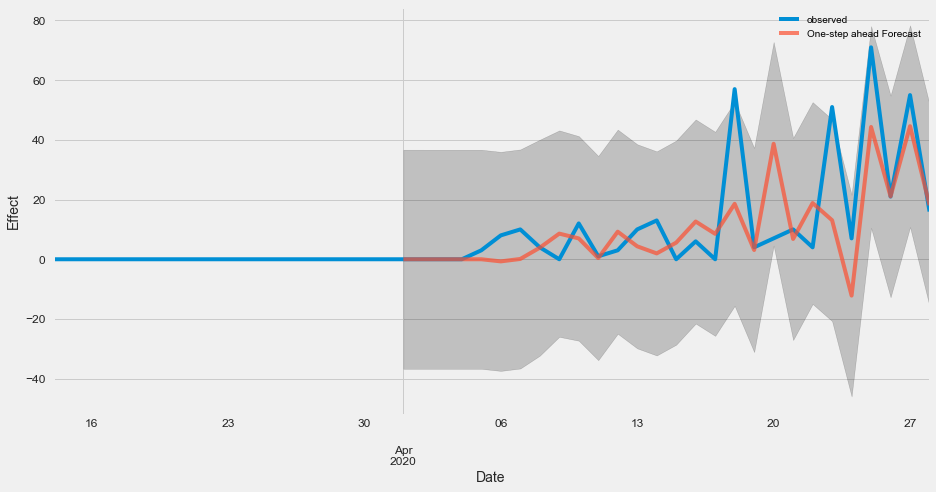

In [67]:
recovered_pred = recovered_results.get_prediction(start=pd.to_datetime('2020-04-01'), dynamic=False)
recovered_pred_ci = recovered_pred.conf_int()
recovered_ax = recovered['2020':].plot(label='observed')
recovered_pred.predicted_mean.plot(ax=recovered_ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
recovered_ax.fill_between(recovered_pred_ci.index,
                recovered_pred_ci.iloc[:, 0],
                recovered_pred_ci.iloc[:, 1], color='k', alpha=.2)
recovered_ax.set_xlabel('Date')
recovered_ax.set_ylabel('Effect')
plt.legend()
plt.show()

In [68]:
recovered_forecasted = recovered_pred.predicted_mean
recovered_truth = recovered['2020-04-01':]
recovered_mse = ((recovered_forecasted - recovered_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(recovered_mse, 2)))

The Mean Squared Error of our forecasts is 213.02


In [69]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(recovered_mse), 2)))

The Root Mean Squared Error of our forecasts is 14.6


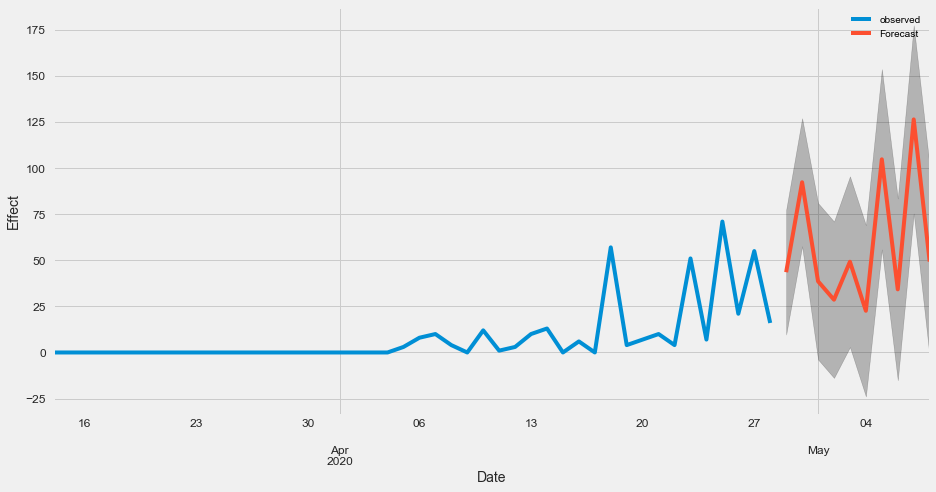

In [70]:
recovered_pred_uc = recovered_results.get_forecast(steps=10)
recovered_pred_ci = recovered_pred_uc.conf_int()
recovered_ax = recovered.plot(label='observed', figsize=(14, 7))
recovered_pred_uc.predicted_mean.plot(ax=recovered_ax, label='Forecast')
recovered_ax.fill_between(recovered_pred_ci.index,
                recovered_pred_ci.iloc[:, 0],
                recovered_pred_ci.iloc[:, 1], color='k', alpha=.25)
recovered_ax.set_xlabel('Date')
recovered_ax.set_ylabel('Effect')
plt.legend()
plt.show()

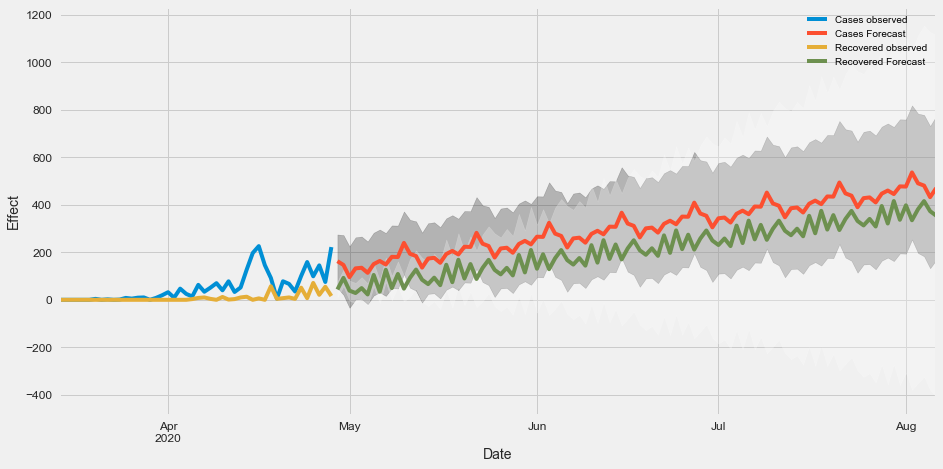

In [71]:
cases_pred_uc = cases_results.get_forecast(steps=100)
cases_pred_ci = cases_pred_uc.conf_int()
cases_ax = cases.plot(label='Cases observed', figsize=(14, 7))
cases_pred_uc.predicted_mean.plot(ax=cases_ax, label='Cases Forecast')
cases_ax.fill_between(cases_pred_ci.index,
                cases_pred_ci.iloc[:, 0],
                cases_pred_ci.iloc[:, 1], color='k', alpha=.25)

recovered_pred_uc = recovered_results.get_forecast(steps=100)
recovered_pred_ci = recovered_pred_uc.conf_int()
recovered_ax = recovered.plot(label='Recovered observed', figsize=(14, 7))
recovered_pred_uc.predicted_mean.plot(ax=recovered_ax, label='Recovered Forecast')
recovered_ax.fill_between(recovered_pred_ci.index,
                recovered_pred_ci.iloc[:, 0],
                recovered_pred_ci.iloc[:, 1], color='w', alpha=.25)

cases_ax.set_xlabel('Date')
cases_ax.set_ylabel('Effect')
recovered_ax.set_xlabel('Date')
recovered_ax.set_ylabel('Effect')
plt.legend()
plt.show()

In [72]:
cases_pred_uc = cases_results.get_forecast(steps=100)
cases_pred_ci = cases_pred_uc.conf_int()
cases_result_date = pd.DataFrame(cases_pred_uc.predicted_mean)

In [73]:
cases_end_date = str(cases_result_date.index[cases_result_date[0]<=0.0].tolist()[0])
print("The predicted last date on which the cases will become 0 is: " + cases_end_date.split()[0])

IndexError: list index out of range

In [74]:
int(np.mean(cases_result_date)[0])

307

In [75]:
int(min(cases_result_date[0]))

95

In [76]:
cases_end_date = str(cases_result_date.index[cases_result_date[0]<=np.ceil(min(cases_result_date[0]))].tolist()[0])
print("The predicted last date on which the cases will become 0 is: " + cases_end_date.split()[0])

The predicted last date on which the cases will become 0 is: 2020-05-01


In [77]:
cases_pred_uc = cases_results.get_forecast(steps=100)
cases_pred_ci = cases_pred_uc.conf_int()
cases_result_date = pd.DataFrame(cases_pred_uc.predicted_mean)

recovered_pred_uc = recovered_results.get_forecast(steps=100)
recovered_pred_ci = recovered_pred_uc.conf_int()
recovered_result_date = pd.DataFrame(recovered_pred_uc.predicted_mean)

In [78]:
cases_end_date = str(cases_result_date.index[recovered_result_date[0]>=int(np.mean(cases_result_date)[0])].tolist()[0])
print("The predicted last date on which the cases will become 0 is: " + cases_end_date.split()[0])

The predicted last date on which the cases will become 0 is: 2020-07-04


In [79]:
cases_end_date = str(cases_result_date.index[recovered_result_date[0]>=int(np.mean(recovered_result_date)[0])].tolist()[0])
print("The predicted last date on which the cases will become 0 is: " + cases_end_date.split()[0])

The predicted last date on which the cases will become 0 is: 2020-06-10


In [80]:
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 9, 6

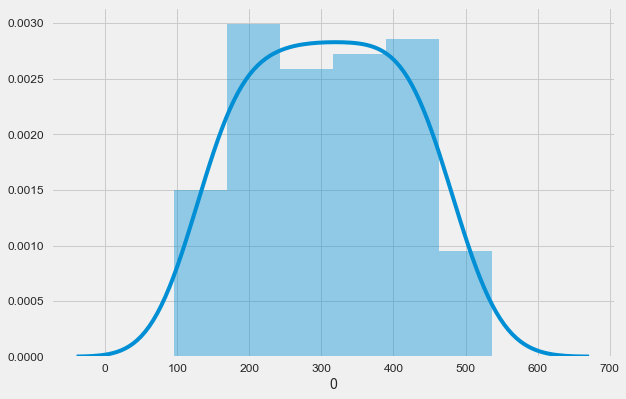

In [81]:
sns.distplot(cases_result_date[0])
plt.show(block=True)

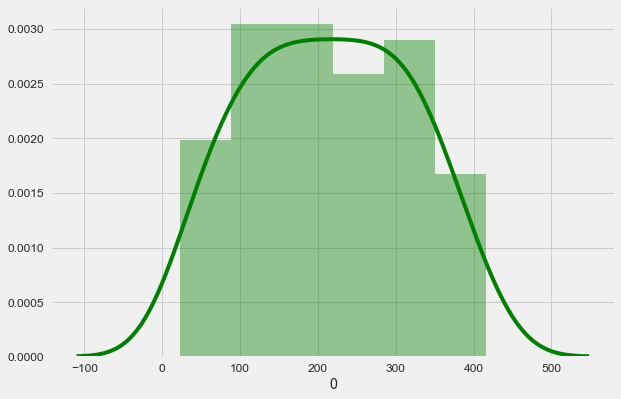

In [82]:
sns.distplot(recovered_result_date[0],color='green')
plt.show(block=True)

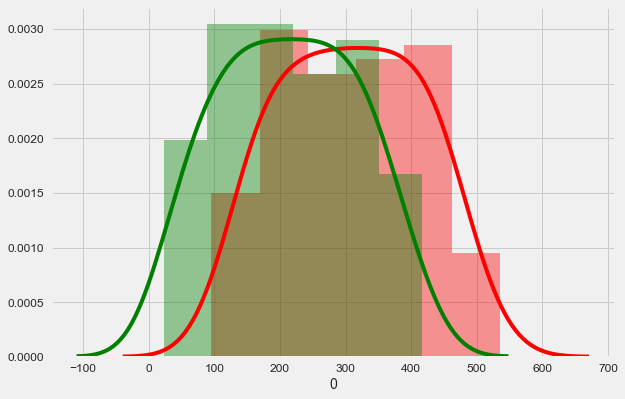

In [83]:
sns.distplot(cases_result_date[0],color='red')
sns.distplot(recovered_result_date[0],color='green')
plt.show(block=True)

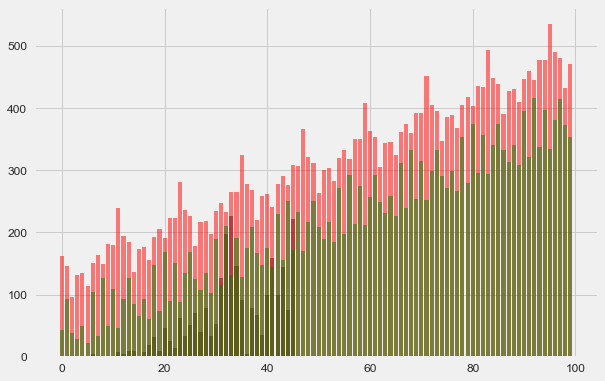

In [84]:
plt.bar([i for i in range(len(total_data['Cases']))], total_data['Cases'], align='center', alpha=0.5, color = 'black')
plt.bar([i for i in range(len(total_data['Recovered']))], total_data['Recovered'][0], align='center', alpha=0.5, color = 'blue')
plt.bar([i for i in range(len(cases_result_date))], cases_result_date[0], align='center', alpha=0.5, color = 'red')
plt.bar([i for i in range(len(recovered_result_date))], recovered_result_date[0], align='center', alpha=0.5, color='green')
plt.show()